<hr style="border:2px solid coral"></hr>

# Parabolic equations

<hr style="border:2px solid coral"></hr>

Many phenomena are modeled as diffusion processs. A classic example is the diffusion of heat through a medium (e.g. air, metals).  Other examples include diffusion of salt in sea water or pollutants in a river. 

The one dimensional parabolic equation is a *time dependent* problem given by the partial differential equation

\begin{equation}
q_t = \beta u_{xx} + S(x,t)
\end{equation}

where $q(x,t)$ is a concentation of some substance, $\beta$ is a diffusion coefficient, and $S(x,t)$ is a source term. 

### Backward Euler discretization

Using the *Backward Euler scheme*, we discretize the equation above in space and time to get an update for the solution at time $t_n = kn$, where $k$ is the time step.  This update is given by

\begin{eqnarray}
q^{n+1}_i & =  & q^n_i + k\left[\beta\frac{q_{i-1}^{n+1} - 2 q_i^{n+1} + q_{i+1}^{n+1}}{h^2}  + S(x_i,t_n)\right]
\end{eqnarray}

Terms involving the solution at time $t_{n+1}$ are moved to the right hand side to get

\begin{equation}
q_i^{n+1} - \frac{k\beta}{h^2}\left(q_{i-1}^{n+1} - 2 q_i^{n+1} + q_{i+1}^{n+1}\right)  = q^n_i + k S(x_i,t_n)
\end{equation}

Multiplying through by $-h^2/\beta k$, we can write the above linear system very similar to the elliptic problem. 

\begin{equation}
q_{i-1}^{n+1} - \left(2 + \frac{h^2}{\beta k}\right)q_{i}^{n+1} + q_{i+1}^{n+1} 
= -\frac{h^2}{k\beta} \left(q_i^n  + kS(x_i,t_n)\right) 
\equiv  \mathbf F^n
\end{equation}

From this system, we see that 

1. Steady state is reached if $q_i^{n+1} = q_i^n$. In this case, the problem reduces to our familiar elliptic discretization of the steady state heat problem 

\begin{equation}
u_t = \beta u_{xx} + S(x,t) = 0
\end{equation}

or 
\begin{equation}
u_{xx} = -\frac{1}{\beta}S(x,t)
\end{equation}

2.  The resulting system of equations can be written as a linear system

\begin{equation}
\left(A -  \frac{h^2}{\beta k}I\right) \mathbf q^{n+1} = 
-\frac{h^2}{k\beta} \left(\mathbf q^n  + k\mathbf S^n\right) \equiv
\mathbf F^n
\end{equation}

where $A$ is our standard $[1,-2,1]$ matrix. The resulting matrix is SPD, and so can be solved using our Conjugate Gradient solver. 

For numerical methods, it is convenient to write the above as 

\begin{equation}
\left(A -  \lambda I\right) \mathbf q^{n+1} = \mathbf F^n
\end{equation}

where $\lambda = h^2/(\beta k) > 0$.  To solve this using a standard CG algorithm, we should pass an additional argument $\lambda$ to our CG and matvec routines. 

In [17]:
%reset -f

In [20]:
from matplotlib.pyplot import *
from numpy import *
from enum import Enum

In [21]:
# Conjugate gradient algorithm

from numpy.linalg import solve, norm

method_types = Enum('method_types', ['SD', 'CG'], start = 0)

def cg(A,F,kmax=10000,tol=1e-12, prt=False, \
       method=method_types.CG,x0 = None):
    if x0 is None:
        xk = zeros(F.shape)
    else:
        xk = x0
    rk = F - A@xk
    pk = rk
    for k in range(kmax):
        
        Apk = A@pk  
        pAp = pk.T@Apk
        if pAp == 0:
            print("pAp == 0")
            xkp1 = xk
            break
        rTr = rk.T@rk
        alpha = rTr/pAp
        xkp1 = xk + alpha*pk
        rkp1 = rk - alpha*Apk
        
        if method == method_types.SD:
            # Steepest descent directions 
            pkp1 = rkp1

        elif method == method_types.CG:
            # A-conjugate search directions 
            beta = rkp1.T@rkp1/rTr    
            pkp1 = rkp1 + beta*pk
        
        err = norm(rkp1,inf)
        itcount = k+1
        if prt:
            print(f"{k:5d} {err:12.4e}")
            
        if err < tol:
            break
        pk = pkp1
        rk = rkp1
        xk = xkp1
        
    xk = xkp1
    return xk,itcount        

In [22]:
# Construct (N-1)x(N-1) tridiagonal linear system.  

bc_types = Enum('bc_types', ['DIRICHLET', 'NEUMANN'], start = 0)

def get_linsys(N,a,b,beta,k,bc=bc_types.DIRICHLET):
    # Using a sparse matrix would be much faster for large N
    h = (b-a)/N
    x = linspace(a,b,N+1).reshape((N+1,1))
    if bc == bc_types.DIRICHLET:
        A = diag(ones(N-2),-1) - 2*diag(ones(N-1)) + diag(ones(N-2),1)
        x = x[1:-1]
        I = eye(N-1)
    elif bc == bc_types.NEUMANN:
        A = diag(ones(N),-1) - 2*diag(ones(N+1)) + diag(ones(N),1)
        A[0,0] = -1
        A[0,1] = 1
        A[-1,-2] = 1
        A[-1,-1] = -1
        I = eye(N+1)
        
    c = h**2/(beta*k)
    B = A - c*I
    return B, x

### Problem setup

Like the elliptic problem, we have to supply a domain interval $[a,b]$ and a mesh size $N$.  For our current problem, we may also want to supply a value for $\beta$. 

But because the problem is time dependent, we also need to supply a final time $T$, and a time step $k$. 

For this problem, we can set the time step $k \approx h$.  Then we compute the number of time steps needed to reach our final time $T$. 


In [23]:
def initial_condition(x):
    return exp(-200*(x-0.5)**2)

# User input
a = 0
b = 1
beta = 0.2
Tfinal = 1.0

# Numerical parameters 
N = 64
h = (b-a)/N

# Estimate a time step
k_est = h
M = int(Tfinal/k_est) + 1
k = Tfinal/M

A,x = get_linsys(N,a,b,beta,k,bc=bc_types.NEUMANN)

A typical time stepping algorithm requires an initial condition and a time stepping loop.  In each iteration of the loop, we will need to update the right hand side

\begin{equation}
\mathbf F^n = -\frac{h^2}{k} \left(\mathbf q^n + k S^n\right) 
\equiv -\lambda \left(\mathbf q^n + k S^n\right)
\end{equation}

where $\lambda = h^2/k$.  


<IPython.core.display.Javascript object>


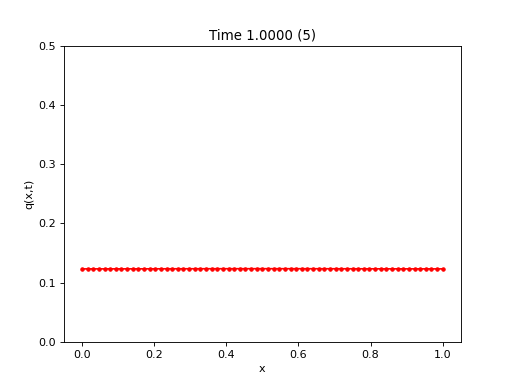

In [24]:
%matplotlib notebook

fig = figure(1)
clf()

qn = initial_condition(x)

hdl, = plot(x,qn,'r.-')

title_str = "Time {t:.4f} ({itcount:d})".format

tstr = title_str(t=0,itcount=0)
title(tstr)

xlabel('x')
ylabel('q(x,t)')
ylim([0,0.5])

fig.canvas.draw() 

pause(1)

prt = 0
for n in range(M+1):
    t = k*n
    Fn = -h**2/(beta*k)*qn
    qnp1,itcount = cg(A,Fn,prt=0,x0=qn)
    if prt:
        print(f"{n:5d} {itcount:8d}")
    
    hdl.set_ydata(qnp1)    
    
    tstr = title_str(t=t,itcount=itcount)
    title(tstr)
    ylim([0,0.5])
    
    fig.canvas.draw();       
        
    pause(0.5)
    
    qn = qnp1


<hr style="border:2px solid coral"></hr>

## Boundary conditions

<hr style="border:2px solid coral"></hr>

Like elliptic problems, we also need boundary conditions for the heat equation solver.  Fortunately, they are implemented in exactly the same way as for the elliptic problem. 

<hr style="border:3px solid coral"/>

# Reaction-diffusion in 2d (in C)

<hr style="border:3px solid coral"/>

An interesting pattern forming system is the spiral wave "reaction-diffusion" system, given by 

\begin{eqnarray}
u_t & = & \nabla^2 u + f(u,v) \\
v_t & = & u - v
\end{eqnarray}

where 

\begin{equation}
f(u,v) = \frac{1}{\varepsilon}u(1-u)\left(u - \frac{v+b}{a}\right)
\end{equation}

For this problem, we will take $\varepsilon=0.02$, $a = 0.75$ and $b = 0.01$.   To see the spirals form, the code should be run to about $T=40$. 

In [25]:
%reset -f

In [5]:
%matplotlib notebook

from numpy import *
from matplotlib.pyplot import *

In [6]:
%%file RD_all_2d.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

enum
{
    DIRICHLET=0,
    NEUMANN
};

enum
{
    LEFT=0,
    RIGHT,
    BOTTOM,
    TOP
};

enum
{
    DIR_X = 0,
    DIR_Y
};

int bc_type[4];

double* allocate_1d(int n, int m)
{
    double *mem = (double*) malloc((n + 2*m)*sizeof(double));
    return mem+m;
}

void free_1d(double **x, int m)
{
    free(*x-m);
    *x = NULL;
}

double** allocate_2d(int n, int m, int mbc)
{
    int rows = n + 2*mbc;
    int cols = m + 2*mbc; 

    double   *qmem = malloc(rows*cols*sizeof(double));
    double **qrows = malloc(rows*sizeof(double*));

    for(int i = 0; i < rows; i++)
    {
        qrows[i] = &qmem[cols*i + mbc];
    }    
    return &qrows[mbc];
}

void free_2d(double ***q,int mbc)
{
    free(&(*q)[-mbc][-mbc]);
    free(&(*q)[-mbc]);
    *q = NULL;
}

Overwriting RD_all_2d.c


In [7]:
%%file cg_serial_fix.c

#include <stdio.h>
#include <stdlib.h>
#include <math.h>

#include "RD_all_2d.c"

int bc_type[4];

void matvec(int N, double **u, double **L, double lambda)
{
    for(int j = 0; j < N; j++)
    {
        u[-1][j] = (bc_type[LEFT] == DIRICHLET)  ? -u[0][j] : u[0][j];
        u[N][j]  = (bc_type[RIGHT] == DIRICHLET) ? -u[N-1][j] : u[N-1][j];
    }

    for(int i = 0; i < N; i++)
    {
        u[i][-1] = (bc_type[BOTTOM] == DIRICHLET) ? -u[i][0] : u[i][0];
        u[i][N] = (bc_type[TOP] == DIRICHLET) ? -u[i][N-1] : u[i][N-1];
    }
                    
    for(int i = 0; i < N; i++)    
        for(int j = 0; j < N; j++)
        {
            L[i][j] = u[i-1][j] + u[i+1][j] + u[i][j-1] + u[i][j+1] - 4*u[i][j]; 
            L[i][j] -= lambda*u[i][j];
        }
}

int cg(int N, double **F, double **u, double lambda, double tol, int kmax, int prt)
{
    // # TODO : Implement at 2d CG solver

    int itcount = 0;
    int i1 =0;
    int i2 = N;
    
    double **uk = allocate_2d(N,N,0);
    double **pk = allocate_2d(N,N,1);    
    double **rk = allocate_2d(N,N,0);
    double **Apk = allocate_2d(N,N,0);
    double **rkp1 = allocate_2d(N,N,0);
    
  
    for(int i = i1; i < i2; i++)
     {
      for(int j = i1; j < i2; j++)
    {
        uk[i][j] = 0;
        rk[i][j] = F[i][j];
        pk[i][j] = rk[i][j];    // # Start with uk = 0 --> r = b - Au = b            
    }   
     }   
   
   
 
    for(int k = 0; k < kmax; k++)
    {
        
        matvec(N, pk, Apk,lambda);
        
        double rTr = 0;
        double pTAp = 0;
        for(int i = i1; i < i2; i++)
        {
            for (int j = i1; j<i2;j++)
            {
            rTr += rk[i][j]*rk[i][j];
            pTAp += pk[i][j]*Apk[i][j]; 
            }
            
        }
         
        
        
        double alpha = rTr/pTAp;
        
        double rpTrp = 0;
        double max_res = 0;
        
        for(int i = i1; i < i2; i++)
        {
            for(int j = i1; j < i2; j++)
            {
                    uk[i][j] = uk[i][j] + alpha*pk[i][j];
                rkp1[i][j] = rk[i][j] - alpha*Apk[i][j];
                rpTrp += rkp1[i][j]*rkp1[i][j];
                max_res = fmax(fabs(rkp1[i][j]),max_res);
            }
        }
    
        
        itcount = k+1;
        
        //printf("%d error = %12.4e\n",k, max_res); 
        if (max_res < tol)
            break;
        
        
        double beta = rpTrp/rTr;
        
        for(int i = i1; i < i2; i++)
        {
         for(int j = i1; j < i2; j++)
            {
              pk[i][j] = rkp1[i][j] + beta*pk[i][j];   
            }
                  
        }
        
       
        for(int i = i1; i < i2; i++)
        {
         for (int j =i1; j<i2;j++)
               rk[i][j] = rkp1[i][j];  
        }
           
        rTr = rpTrp;
        
    }
    
    for(int i = i1; i < i2; i++)
    {
      for(int j = i1; j < i2; j++)
        {
          u[i][j] = uk[i][j];    
        }
             
    }
    
    
    
    free_2d(&uk,0);
    free_2d(&pk,1);
    free_2d(&rk,0);
    free_2d(&rkp1,0);
    free_2d(&Apk,0);

    
    
    return itcount;
    
}


Overwriting cg_serial_fix.c


In [8]:
%%file spiral_serial.c

#include <stdio.h>
#include <stdlib.h>

#include <math.h>

#include "cg_serial_fix.c"

int main(int argc, char** argv)
{
    int N, nout;
    double Tfinal;
    if (argc == 4)
    {
        N = atoi(argv[1]);
        nout = atoi(argv[2]);     // # Number of time steps
        Tfinal = atof(argv[3]);
    }
    else
    {
        printf("spiral <N> <nout> <Tfinal>\n");
        exit(0);
    }

    for(int i = 0; i < 4; i++)
        bc_type[i] = NEUMANN;
    
    double L = 20;
    double a = -L, b = L;


    // Model parameters 
    double a_model = 0.75;
    double b_model = 0.01;
    double e_model = 0.02;

    // --------------------------- Numerical parameters -------------------------------
    double h = (b-a)/N;

    int kmax = 1000;
    double tol = 1e-12;
    int prt = 0;
    // ---------------------------- Initialize solution -------------------------------

    double **u = allocate_2d(N,N,1);
    double **v = allocate_2d(N,N,1);

    for(int i = -1; i < N+1; i++)
    {
        double x = a + (i+0.5)*h;
        for(int j = -1; j < N+1; j++)
        {
            double y = a + (j+0.5)*h;
            u[i][j] = (y > 0) ? 1 : 0;           
            v[i][j] = (x > 0) ? 1 : 0;
        }
    }

    // ----------------------------- Compute time step ---------------------------------
    // # Compute a stable time step
    // # 1.  Estimate a stable time step 'dt_stable'.   This may not evenly divide Tfinal. 
    // # 2.  Compute a minimum number M of time steps we need to take.
    // # 3.  Divide Tfinal by M to get get a dt that is guaranteed smaller than dt_est and  
    // #     satisfies M*dt = Tfinal.

        
    double dt_est = h/30;
    
    
    double dT = Tfinal/nout;
    int M_inner = ceil(dT/dt_est) + 1;   // # Compute M to guarantee we hit Tfinal
    double dt = dT/M_inner;
    int M = nout*M_inner;
    printf("dt = %f\n",dt);
    
    // # Time stepping
    double **up = allocate_2d(N,N,1);
    double **vp = allocate_2d(N,N,1);

    // #  Write out meta data 
    FILE *fout = fopen("spiral.dat","w");        
    fwrite(&N,1,sizeof(int),fout);
    fwrite(&nout,1,sizeof(int),fout);
    fwrite(&a,1,sizeof(double),fout);
    fwrite(&b,1,sizeof(double),fout);

    double t = 0;
    int Frame = 0;
    fwrite(&t,1,sizeof(double),fout);    
    printf("Frame %5d (step %5d)  t = %8.4f (itcount = %d)\n",Frame,0,t,0);    
    for(int i = 0; i < N; i++)
        fwrite(u[i],N,sizeof(double),fout);        
    
    for(int i = 0; i < N; i++)
        fwrite(v[i],N,sizeof(double),fout);        
    
    //M+1
    double **F = allocate_2d(N,N,0);
    double lambda = h*h/dt;
    for(int n = 0; n < M+1; n++)
    {
        for(int i = 0; i < N; i++)
            for(int j = 0; j < N; j++)
            {
                double uij = u[i][j];
                double vij = v[i][j];
                double S = uij*(1-uij)*(uij - (vij+b_model)/a_model)/e_model;
                F[i][j] = -lambda*(u[i][j] + dt*S);
                //printf("F[%d][%d] = %f\n",i,j,F[i][j]);
                up[i][j] = u[i][j];
               //printf("up[%d][%d] = %f, S = %f\n",i,j,up[i][j],S);
            }
        
        int itcount = 0;
        itcount = cg(N,F,up,lambda,tol,kmax,prt);
        if (prt == 1)
            printf("Iteration count (CG) : %d\n",itcount);
                
        for(int i = 0; i < N; i++)
            for(int j = 0; j < N; j++)
                {
                    vp[i][j] = v[i][j] + dt*(up[i][j] - v[i][j]);
                    //printf("up[%d][%d] = %f\n",i,j,up[i][j]);
                }

        // # Write out current solution
        t += dt;
        if ((n+1)%M_inner == 0)
        {
            Frame++;
            printf("Frame %5d (step %5d)  t = %8.4f (itcount = %d)\n",Frame,n+1,t,itcount);    
            
            fwrite(&t,sizeof(double),1,fout);
            for(int i = 0; i < N; i++)
                fwrite(up[i],sizeof(double),N, fout);             
        
            for(int i = 0; i < N; i++)
                fwrite(vp[i],sizeof(double),N, fout);  
        }
        
        for(int i = 0; i < N; i++)
            for(int j = 0; j < N; j++)
            {
                u[i][j] = up[i][j];
                v[i][j] = vp[i][j];
                //printf("up = %f, vp = %f, i = %d, j = %d\n",up[i][j],vp[i][j], i, j);
            }
    }
    fclose(fout);

    free_2d(&u,1);
    free_2d(&v,1);

    return 0;
}

Overwriting spiral_serial.c


In [18]:
%%bash

rm -rf spiral_serial.o spiral_serial

rm -rf spiral.dat

gcc -o spiral spiral_serial.c

# spiral <N> <nout> <Tfinal>
./spiral 128 10 70

dt = 0.010401
Frame     0 (step     0)  t =   0.0000 (itcount = 0)
Frame     1 (step   673)  t =   7.0000 (itcount = 16)
Frame     2 (step  1346)  t =  14.0000 (itcount = 16)
Frame     3 (step  2019)  t =  21.0000 (itcount = 16)
Frame     4 (step  2692)  t =  28.0000 (itcount = 16)
Frame     5 (step  3365)  t =  35.0000 (itcount = 16)
Frame     6 (step  4038)  t =  42.0000 (itcount = 16)
Frame     7 (step  4711)  t =  49.0000 (itcount = 16)
Frame     8 (step  5384)  t =  56.0000 (itcount = 16)
Frame     9 (step  6057)  t =  63.0000 (itcount = 16)
Frame    10 (step  6730)  t =  70.0000 (itcount = 16)


In [19]:
import os

fout = open("spiral.dat","rb")
N,nout, = fromfile(fout,dtype=int32,count=2)
fout.close()

stats = os.stat("spiral.dat")
print(f"File size          : {stats.st_size:d} bytes ({stats.st_size/1024**2:.2f} mB)")

esize = 2*4 + 8*(2 + (nout+1)*(2*N**2+1))
print(f"Expected file size : {esize:d} bytes")

File size          : 2883696 bytes (2.75 mB)
Expected file size : 2883696 bytes


<IPython.core.display.Javascript object>


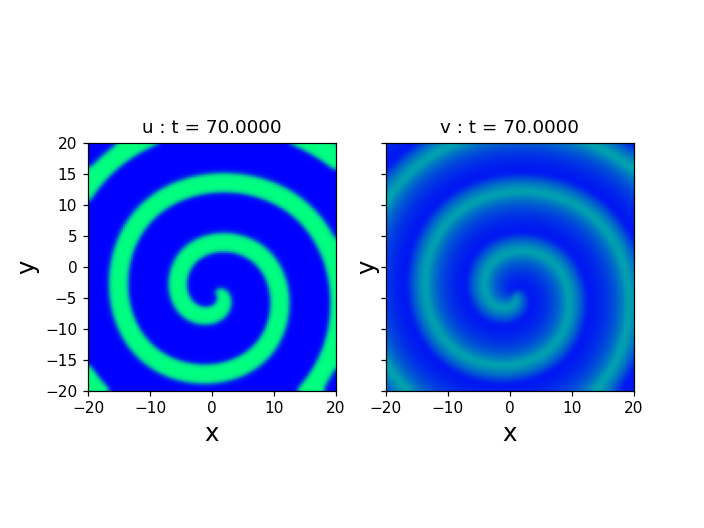

N=128
nout=10
a=-20.000000
b=20.000000
u.min()=  2.89928824e-10
u.max()=  9.99997080e-01
v.min()=  9.21005422e-02
v.max()=  6.42695960e-01


In [20]:
fig,ax = subplots(1,2,sharey=True)

dt = dtype([('N',int32),\
            ('nout',int32), \
            ('a',float64),\
            ('b',float64)])

fout = open("spiral.dat","rb")
N,nout,a,b = fromfile(fout,dtype=dt, count=1)[0]


dt1 = dtype([('t',float64),('u',float64,N*N),('v',float64,N*N)])
t,u,v = fromfile(fout,dtype=dt1,count=1)[0]
u = reshape(u,(N,N))
v = reshape(v,(N,N))

from matplotlib import colormaps

# Plot initial solution and store handle
extent = [a,b,a,b]

# Add title, axis labels, etc
im_u = ax[0].imshow(u.T,vmin=0,vmax=1,extent=extent,origin='lower',cmap='winter');
ax[0].set_title(f'u : t = {t:.4f}')
ax[0].set_xlabel('x',fontsize=16)
ax[0].set_ylabel('y', fontsize=16)

im_v = ax[1].imshow(v.T,vmin=0,vmax=1,extent=extent,origin='lower',cmap='winter');
ax[1].set_title(f'v : t = {t:.4f}')
ax[1].set_xlabel('x',fontsize=16)
ax[1].set_ylabel('y', fontsize=16)


# Make axis square
ax[0].set_aspect('equal')
ax[1].set_aspect('equal')


fig.canvas.draw() 

pause(1)



for i in range(nout):
    t,u,v = fromfile(fout,dtype=dt1,count=1)[0]
    
    u = reshape(u,(N,N))
    v = reshape(v,(N,N))    
    umax = u.max()
    vmax = v.max()


    im_u.set_data(u.T)
    tstr = f"u : t = {t:.4f}"
    ax[0].set_title(tstr)
    ax[0].set_aspect('equal')

    im_v.set_data(v.T)
    tstr = f"v : t = {t:.4f}"
    ax[1].set_title(tstr)
    ax[1].set_aspect('equal')
        
    fig.canvas.draw()
    
    pause(2)
    
fout.close()    

print(f"{N=:d}")
print(f"{nout=:d}")
print(f"{a=:f}")
print(f"{b=:f}")
print(f"{u.min()=:16.8e}")
print(f"{u.max()=:16.8e}")
print(f"{v.min()=:16.8e}")
print(f"{v.max()=:16.8e}")

<hr style="border: 2px coral solid"></hr>

### Phase field diagram

<hr style="border: 2px coral solid"></hr>


In [ ]:
assert 1==0, "Don't run beyond this point."

In [29]:
%reset -f

In [30]:
%matplotlib notebook
from numpy import *
from matplotlib.pyplot import *

import scipy
from scipy.integrate import solve_ivp

<IPython.core.display.Javascript object>


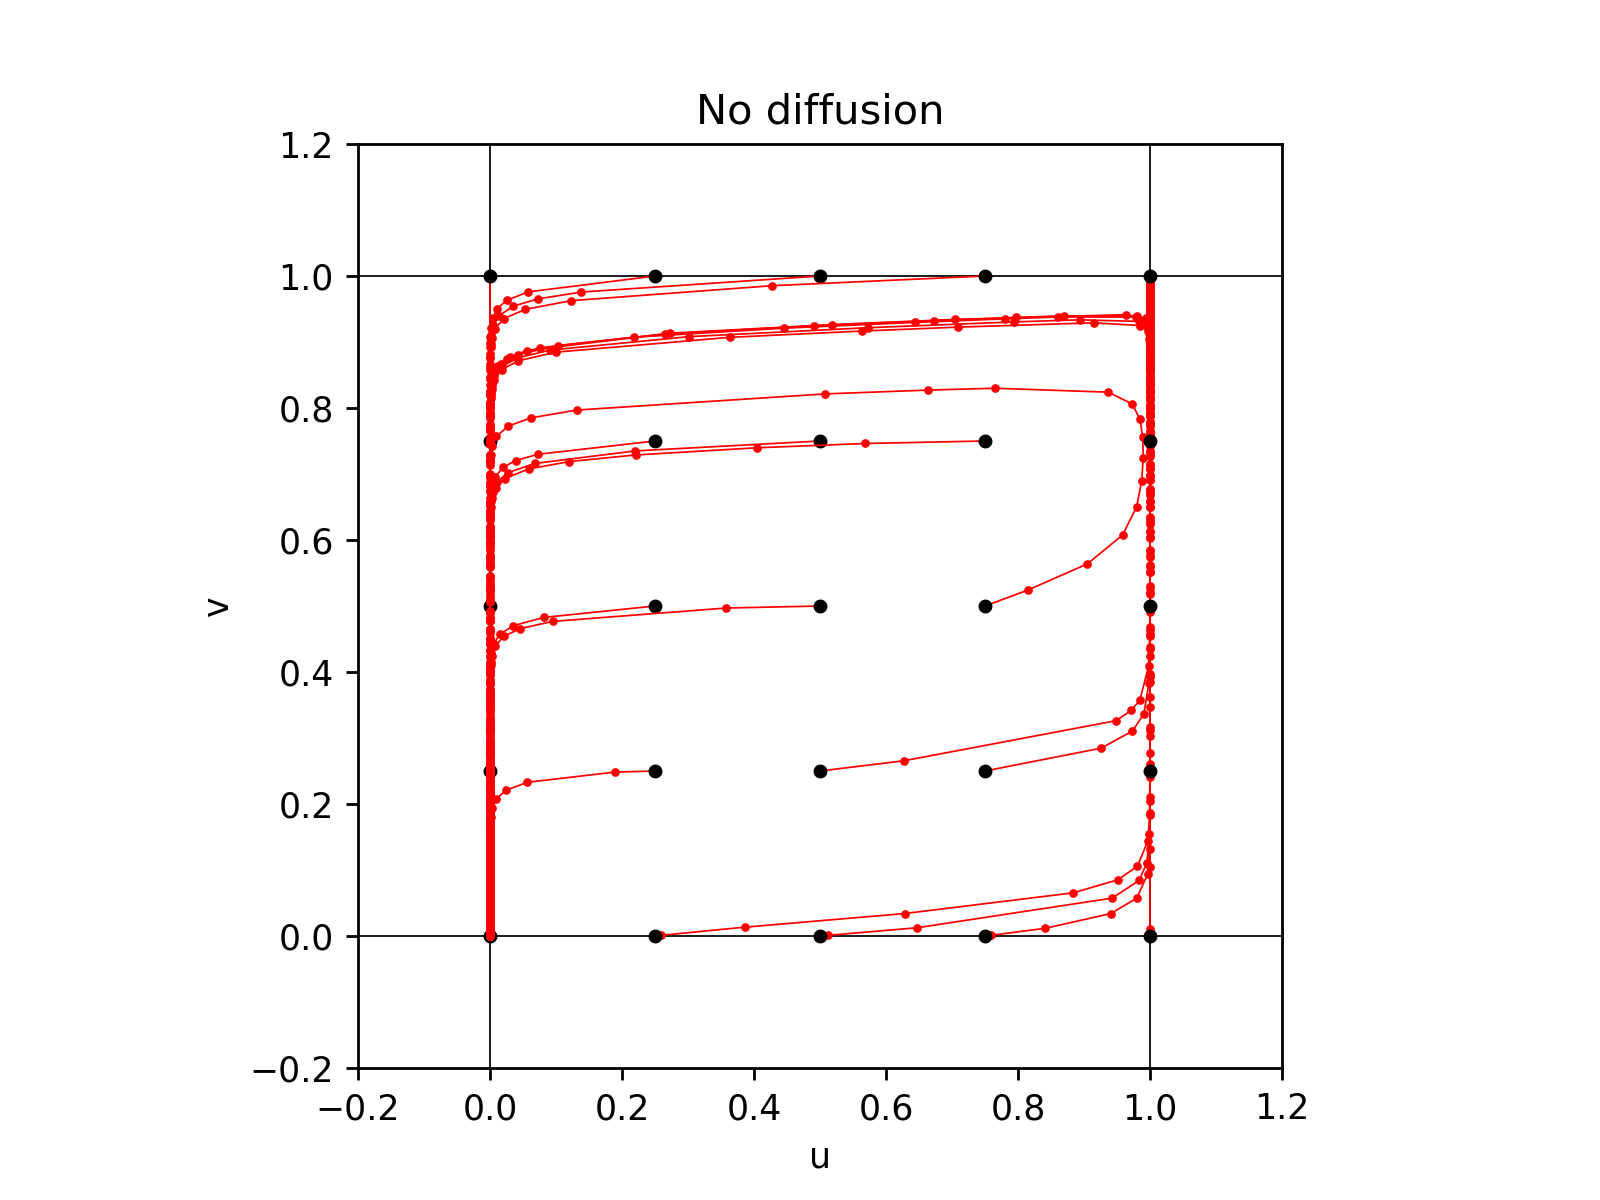

In [31]:
fig = figure(10)
clf()

import itertools

def func(t,y,dt):
    a_model = 0.75;
    b_model = 0.01;
    e_model = 0.02;

    u = y[0]
    v = y[1]
    
    # Apply a "diffusion" step
    et = exp(-dt) if with_diffusion else 1
    u *= et
    
    f = u*(1-u)*(u - (v+b_model)/a_model)/e_model
    g = u - v
    
    return array([f,g])


def create_phase_diagram(fig,m,Tfinal,dt,m1=None,m2=None):
    
    axhline(lw=0.5,color='k')
    axvline(lw=0.5,color='k')
    axhline(1,lw=0.5,color='k')
    axvline(1,lw=0.5,color='k')
    xlabel('u')
    ylabel('v')
    axis([-0.2,1.2,-0.2,1.2])
    gca().set_aspect('equal');

    fig.canvas.draw() 

    m1 = m if m1 is None else m1
    m2 = m if m2 is None else m2
    ij = itertools.product(range(m1+1),range(m2+1))
    for i,j in ij:
        u0 = i/m1
        v0 = j/m2
        y0 = array([u0,v0],dtype=float64)
        y = solve_ivp(func,t_span=[0,Tfinal],y0 = y0,max_step=dt,args=(dt,))
        u = y.y[0]
        v = y.y[1]
        plot(u,v,'r.-',ms=3,lw=0.5)
        plot(u0,v0,'k.',ms=6)

        fig.canvas.draw() 

    
N = 32
L = 20  # Domain size [-L,L]x[-L,L]
h = 2*L/N;
dt = h/10


t = 0
Tfinal = 10    

m = 4

with_diffusion = False
create_phase_diagram(fig,m,Tfinal,dt,m1=4,m2=4)
if with_diffusion:
    title('With diffusion')
else:
    title('No diffusion')
